In [2]:
from chronos import ChronosPipeline
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

# 1. Load the Chronos model
pipeline = ChronosPipeline.from_pretrained(
    "/home/arda/Documents/chronos-forecasting/notebooks/output/distill-29/checkpoint-100000",  # You can use other model sizes too
    device_map="cpu",  # Use "cpu" for CPU inference
    torch_dtype=torch.float32,
)
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")


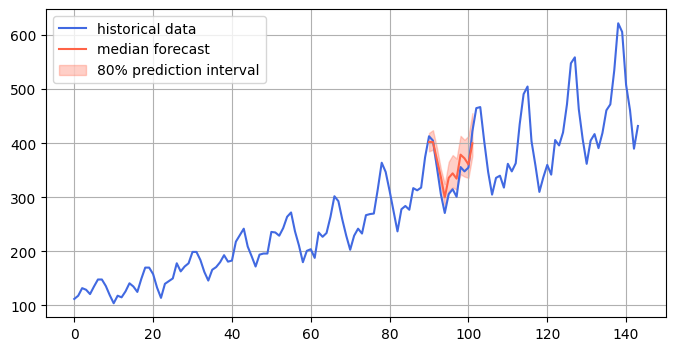

In [24]:



# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])[:90]
prediction_length = 12
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(context), len(context) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()


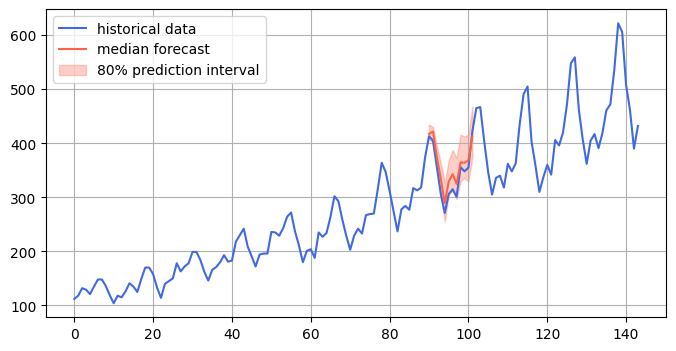

In [21]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cpu",
  torch_dtype=torch.float32,
)






# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])[:90]
prediction_length = 12
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(context), len(context) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()


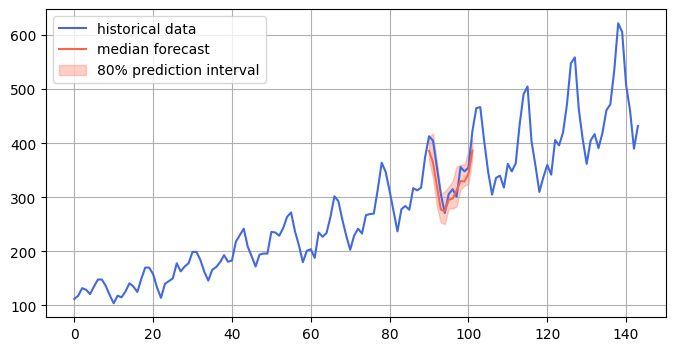

In [22]:
pipeline = ChronosPipeline.from_pretrained(
  "/home/arda/Documents/chronos-forecasting/notebooks/output/run-16/checkpoint-final",
  device_map="cpu",
  torch_dtype=torch.float32,
)






# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])[:90]
prediction_length = 12
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(context), len(context) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()



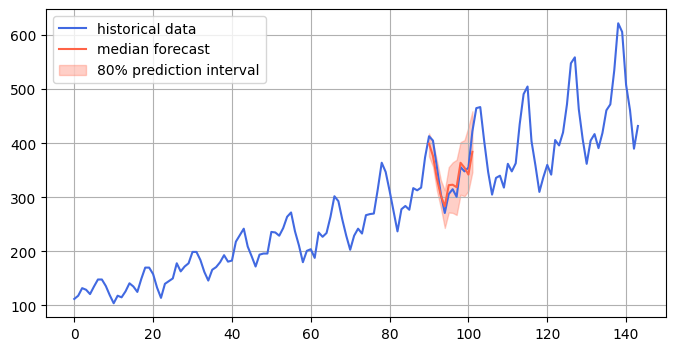

In [25]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-mini",
  device_map="cpu",
  torch_dtype=torch.float32,
)





# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])[:90]
prediction_length = 12
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(context), len(context) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()



In [2]:
import torch
import pandas as pd
import numpy as np
from chronos import ChronosPipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# If you want to use a neural network classifier instead
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate=0.5):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.network(x)
# 1. Load the Chronos model
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",  # You can use other model sizes too
    device_map="cpu",  # Use "cpu" for CPU inference
    torch_dtype=torch.float32,
)

# 2. Function to extract embeddings for a dataset
def extract_chronos_embeddings(time_series_list):
    """
    Extract Chronos embeddings for a list of time series.
    
    Args:
        time_series_list: List of time series (each as numpy array or torch tensor)
    
    Returns:
        numpy array of embeddings
    """
    # Convert to torch tensor if needed
    if isinstance(time_series_list[0], np.ndarray):
        time_series_list = [torch.tensor(x) for x in time_series_list]
    
    # Get embeddings using Chronos
    embeddings, _ = pipeline.embed(time_series_list)
    
    # Average pooling over the time dimension to get a fixed-size representation
    # You could also try max pooling or other pooling strategies
    embeddings_pooled = embeddings.mean(dim=1)
    
    return embeddings_pooled.cpu().numpy()

# 3. Example usage with a classification task
def train_classifier(X_time_series, y_labels, num_epochs=100, batch_size=32):
    """
    Train a neural network classifier using Chronos embeddings
    """
    # Extract embeddings
    X_embeddings = extract_chronos_embeddings(X_time_series)
    label_encoder = LabelEncoder()
    y_labels_encoded = label_encoder.fit_transform(y_labels)
    # Convert to PyTorch tensors
    X_embeddings = torch.FloatTensor(X_embeddings)
    y_labels = torch.LongTensor(y_labels_encoded)  # Now using encoded labels
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_embeddings, y_labels, test_size=0.2, random_state=42
    )
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    num_classes = len(torch.unique(y_labels))
    model = SimpleClassifier(
        input_dim=X_embeddings.shape[1],
        num_classes=num_classes,
        dropout_rate=0.5
    )
    
    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = 'cpu'
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10, verbose=True
    )
    
    # Training loop
    best_test_acc = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            # Training accuracy
            X_train_gpu = X_train.to(device)
            train_outputs = model(X_train_gpu)
            _, predicted = torch.max(train_outputs, 1)
            train_acc = (predicted.cpu() == y_train).float().mean().item()
            
            # Test accuracy
            X_test_gpu = X_test.to(device)
            test_outputs = model(X_test_gpu)
            _, predicted = torch.max(test_outputs, 1)
            test_acc = (predicted.cpu() == y_test).float().mean().item()
        
        # Update learning rate
        scheduler.step(train_loss)
        
        # Save best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_state = model.state_dict()
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Training accuracy: {train_acc:.3f}')
            print(f'Test accuracy: {test_acc:.3f}')
            print(f'Loss: {train_loss/len(train_loader):.4f}\n')
    
    # Load best model
    model.load_state_dict(best_state)
    print(f'\nBest test accuracy: {best_test_acc:.3f}')
    
    return model


# 4. Example with UCR/UEA time series dataset
def load_ucr_dataset(dataset_name):
    """
    Load a dataset from the UCR/UEA archive
    You'll need to download the dataset first
    """
    from sktime.datasets import load_from_tsfile_to_dataframe
    
    # Load train data
    X_train, y_train = load_from_tsfile_to_dataframe(
        dataset_name + "_TRAIN", return_separate_X_and_y=True
    )
    
    # Load test data
    X_test, y_test = load_from_tsfile_to_dataframe(
        dataset_name + "_TEST", return_separate_X_and_y=True
    )
    
    # Convert to numpy arrays
    X_train = np.array([x.values for x in X_train.iloc[:, 0]])
    X_test = np.array([x.values for x in X_test.iloc[:, 0]])
    
    return X_train, y_train, X_test, y_test

# Usage example
if __name__ == "__main__":
    # Load a real dataset (GunPoint is a simple binary classification dataset)
    dataset_name = "GunPoint"
    X_train, y_train, X_test, y_test = load_ucr_dataset(dataset_name)
    
    # Combine train and test for our own train/test split
    X_combined = np.concatenate([X_train, X_test])
    y_combined = np.concatenate([y_train, y_test])
    
    # Train classifier
    classifier = train_classifier(X_combined, y_combined)

KeyboardInterrupt: 

In [24]:
y_train

array(['2', '2', '1', '1', '2', '2', '2', '2', '2', '1', '1', '1', '1',
       '1', '2', '1', '2', '2', '1', '2', '1', '1', '1', '2', '1', '2',
       '1', '1', '2', '1', '1', '2', '2', '1', '2', '1', '2', '2', '2',
       '2', '2', '1', '1', '1', '2', '2', '1', '2', '1', '2'], dtype='<U1')

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
import time

def train_dtw_classifier(X_time_series, y_labels):
    """
    Train a DTW-based k-NN classifier
    
    Args:
        X_time_series: List of time series data
        y_labels: List/array of corresponding labels
    """
    # Split into train/test (using same split as Chronos for fair comparison)
    X_train, X_test, y_train, y_test = train_test_split(
        X_time_series, y_labels, test_size=0.2, random_state=42
    )
    
    # Normalize the data
    scaler = StandardScaler()
    X_train_2d = X_train.reshape(X_train.shape[0], -1)
    X_test_2d = X_test.reshape(X_test.shape[0], -1)
    X_train_2d = scaler.fit_transform(X_train_2d)
    X_test_2d = scaler.transform(X_test_2d)
    X_train = X_train_2d.reshape(X_train.shape)
    X_test = X_test_2d.reshape(X_test.shape)
    
    # Train DTW-kNN classifier
    start_time = time.time()
    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")
    knn_dtw.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Evaluate
    start_time = time.time()
    train_score = knn_dtw.score(X_train, y_train)
    test_score = knn_dtw.score(X_test, y_test)
    inference_time = time.time() - start_time
    
    print("\nDTW-kNN Results:")
    print(f"Training accuracy: {train_score:.3f}")
    print(f"Test accuracy: {test_score:.3f}")
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Inference time: {inference_time:.2f} seconds")
    
    return knn_dtw

# Modified main section to compare both methods
if __name__ == "__main__":
    # Load dataset
    dataset_name = "GunPoint"
    X_train, y_train, X_test, y_test = load_ucr_dataset(dataset_name)
    
    # Combine train and test for our own train/test split
    X_combined = np.concatenate([X_train, X_test])
    y_combined = np.concatenate([y_train, y_test])
    
    print("Dataset shape:", X_combined.shape)
    print("Number of classes:", len(np.unique(y_combined)))
    
    # Train Chronos-based classifier
    print("\nChronos-based Classification:")
    start_time = time.time()
    chronos_classifier = train_classifier(X_combined, y_combined)
    print(f"Total time: {time.time() - start_time:.2f} seconds")
    
    # Train DTW-based classifier
    print("\nDTW-based Classification:")
    dtw_classifier = train_dtw_classifier(X_combined, y_combined)

ImportError: cannot import name '_add_to_diagonal' from 'sklearn.utils._array_api' (/home/arda/anaconda3/envs/chronos/lib/python3.10/site-packages/sklearn/utils/_array_api.py)